# Surgery pipeline with TRVAE - comparison between zero-, one-shot and full query training

In [1]:
import scib

In [2]:
import os
import timeit
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
Global seed set to 0
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnin

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas. We strongly suggest to use earlystopping to avoid over-fitting. The best earlystopping criteria is the 'val_unweighted_loss' for TRVAE.

In [5]:
condition_key = 'batch'
cell_type_key = 'final_annotation'
target_conditions = ["Oetjen_A","Sun_sample1_CS"]
#Min number cells batch
# target_conditions = ['Villani']


trvae_epochs = 500
alpha_epoch = 200 
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [6]:
url = 'https://figshare.com/ndownloader/files/25717328'
output = 'Immune_ALL_human.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://figshare.com/ndownloader/files/25717328
To: /home/icb/aleksandra.topalova/scarches/notebooks/Immune_ALL_human.h5ad
100%|██████████| 2.06G/2.06G [09:04<00:00, 3.79MB/s]


'Immune_ALL_human.h5ad'

In [7]:
adata = sc.read('Immune_ALL_human.h5ad')

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/batch' was written without encoding metadata.
  categories = read_elem(categories_dset)
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/batch' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:584: 

In [8]:
min_batch = adata.obs.groupby(['batch'])['batch'].count()
min_batch

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


batch
10X               10727
Freytag            3347
Oetjen_A           2586
Oetjen_P           3265
Oetjen_U           3730
Sun_sample1_CS     1725
Sun_sample2_KC     2281
Sun_sample3_TB     2403
Sun_sample4_TC     2420
Villani            1022
Name: batch, dtype: int64

In [9]:
adata.obs.head(3)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,batch,chemistry,data_type,dpt_pseudotime,final_annotation,mt_frac,n_counts,n_genes,sample_ID,size_factors,species,study,tissue
index,,,,,,,,,,,,,
AAACCTGCAGCGAACA-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,CD16+ Monocytes,0.047970,6379.0,1862.0,0,0.957719,Human,Oetjen,Bone_Marrow
AAACCTGCATGTCCTC-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,CD4+ T cells,0.024928,4172.0,1082.0,0,0.425532,Human,Oetjen,Bone_Marrow
AAACCTGGTCGACTGC-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,CD14+ Monocytes,0.051907,6608.0,1618.0,0,0.773111,Human,Oetjen,Bone_Marrow


In [34]:
adata.X = adata.layers["counts"].copy()

This line makes sure that count data is in the adata.X. Remember that count data in adata.X is necessary when using "nb" or "zinb" loss. However, when using trVAE with MSE loss normalized data is necessary in adata.X

In [35]:
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
source_conditions = source_adata.obs[condition_key].unique().tolist()

In [36]:
source_adata

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


View of AnnData object with n_obs × n_vars = 29195 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [37]:
target_adata

View of AnnData object with n_obs × n_vars = 4311 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [38]:
source_adata.raw = source_adata
sc.pp.normalize_total(source_adata)
sc.pp.log1p(source_adata)

In [39]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [40]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
source_adata

AnnData object with n_obs × n_vars = 29195 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

### Create TRVAE model and train it on reference dataset

Create the trVAE model instance with NB loss as default. Insert "recon_loss='mse'," or "recon_loss='zinb'," to change the reconstruction loss.

In [42]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 8
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 8
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [43]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=alpha_epoch,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

 |████----------------| 22.2%  - val_loss: 907.8620764691 - val_recon_loss: 856.3618057914 - val_kl_loss: 23.0567413828 - val_mmd_loss: 38.81906144528
ADJUSTED LR
 |██████--------------| 32.2%  - val_loss: 914.2495966372 - val_recon_loss: 854.2724290931 - val_kl_loss: 19.6884938116 - val_mmd_loss: 44.2263828775
ADJUSTED LR
 |██████--------------| 33.6%  - val_loss: 910.5127802310 - val_recon_loss: 852.2153001868 - val_kl_loss: 19.4767902208 - val_mmd_loss: 42.0343581490
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 146


### Create anndata file of latent representation and compute UMAP

In [44]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


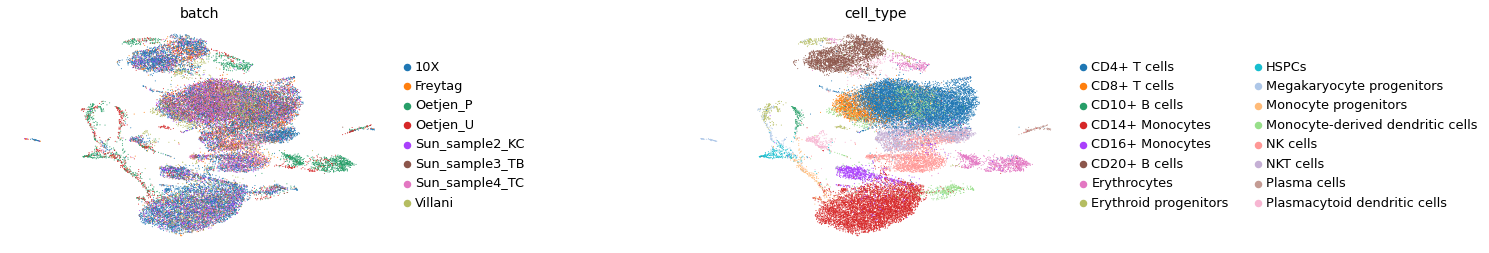

In [45]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use

In [46]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
target_adata = target_adata[:, source_adata.var_names]
target_adata

View of AnnData object with n_obs × n_vars = 4311 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

### Perform surgery on reference model and train on query dataset using one-shot mapping

In [126]:
start_time_1 = timeit.default_timer()

query_model_one = trvae.one_shot_surgery(target_adata, ref_path, copy=False, pretrain = 1)

time_one = timeit.default_timer() - start_time_1
print(f'Executed in {time_one} seconds') 

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AnnData object with n_obs × n_vars = 4311 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', '_original_batch'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 8
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 8
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

Device cpu
Processing original category: Oetjen_A n_obs: 2586
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing 10X
  processing Sun_sample2_KC
  processing Sun_sample3_TB
  processing Sun_sample4_TC
  processing Villani
Processing original category: Sun_sample1_CS n_obs: 1725
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing 10X
  processing Sun_sample2_KC
  processing Sun_sample3_

### Perform surgery on reference model and train on query dataset using zero-shot mapping

In [127]:
start_time_0 = timeit.default_timer()

query_model_zero = trvae.one_shot_surgery(target_adata, ref_path, copy=False, pretrain = 0)

time_zero = timeit.default_timer() - start_time_0
print(f'Executed in {time_zero} seconds')

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AnnData object with n_obs × n_vars = 4311 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', '_original_batch'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 8
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 8
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

Device cpu
Processing original category: Oetjen_A n_obs: 2586
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing 10X
  processing Sun_sample2_KC
  processing Sun_sample3_TB
  processing Sun_sample4_TC
  processing Villani
Processing original category: Sun_sample1_CS n_obs: 1725
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing 10X
  processing Sun_sample2_KC
  processing Sun_sample3_

### Perform surgery on reference model and train on query dataset using full query training

In [128]:
query_model_full = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=ref_path)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AnnData object with n_obs × n_vars = 4311 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', '_original_batch'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 10
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [129]:
start_time_f = timeit.default_timer()

query_model_full.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=alpha_epoch,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

time_full = timeit.default_timer() - start_time_f
print(f'Executed in {time_full} seconds') 

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 |███-----------------| 17.0%  - val_loss: 708.8089294434 - val_recon_loss: 699.5784149170 - val_kl_loss: 20.8260989189 - val_mmd_loss: 0.4835615158
ADJUSTED LR
 |███-----------------| 18.4%  - val_loss: 693.5695190430 - val_recon_loss: 683.6907348633 - val_kl_loss: 20.7126951218 - val_mmd_loss: 0.4545111656
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 70
Executed in 49.176211627200246 seconds


#### Time Benchmarking results

In [130]:
time_zero

1.5123934745788574

In [131]:
time_one

16.076946325600147

In [132]:
time_full

49.176211627200246

#### Latent Representations

In [133]:
surg_path = ['query_model_zero', 'query_model_one', 'query_model_full']

In [134]:
adata_latent_array = []
models = [query_model_zero, query_model_one, query_model_full]

In [135]:
for model in models:
    adata_latent = sc.AnnData(model.get_latent())
    adata_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
    adata_latent.obs['batch'] = target_adata.obs[condition_key].tolist()
    adata_latent_array.append(adata_latent)

In [136]:
adata_latent_array

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[AnnData object with n_obs × n_vars = 4311 × 10
     obs: 'cell_type', 'batch',
 AnnData object with n_obs × n_vars = 4311 × 10
     obs: 'cell_type', 'batch',
 AnnData object with n_obs × n_vars = 4311 × 10
     obs: 'cell_type', 'batch']

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


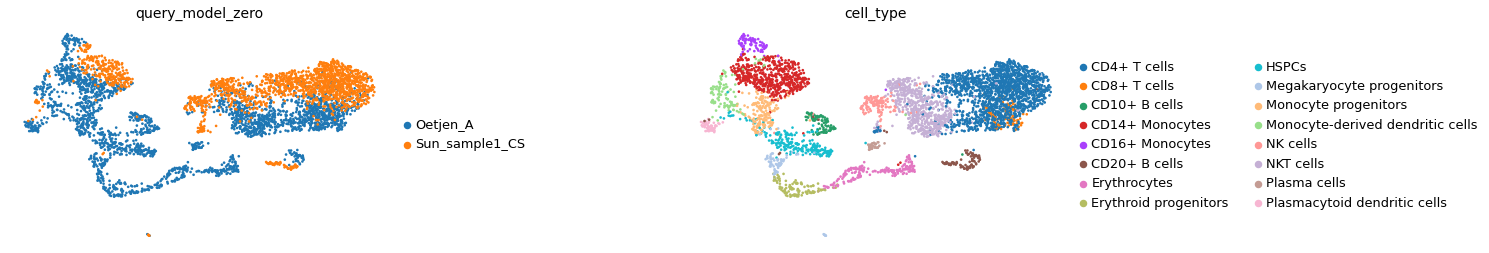

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


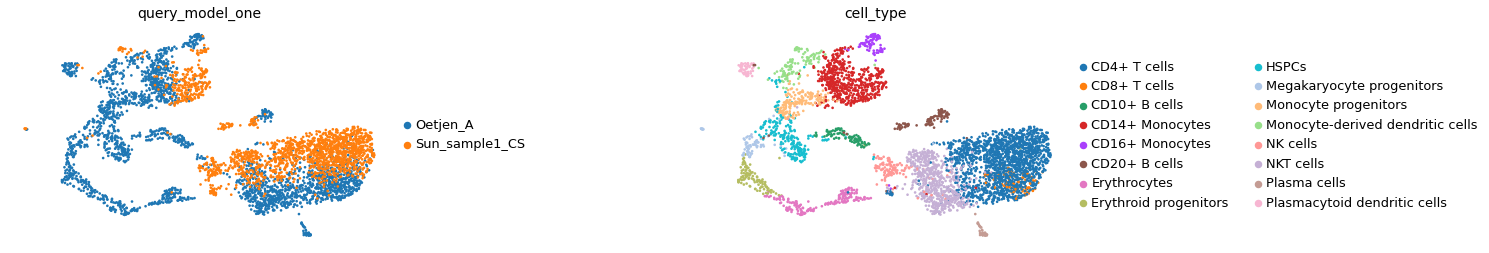

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


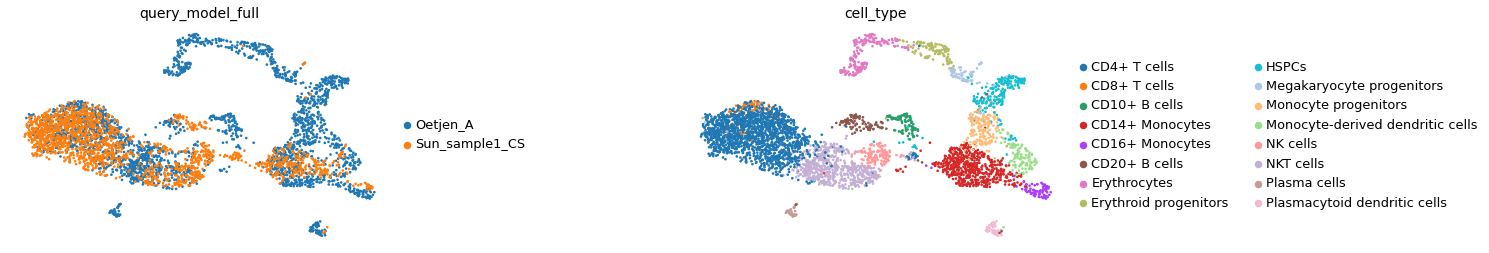

In [137]:
for i in range(len(adata_latent_array)):
    sc.pp.neighbors(adata_latent_array[i], n_neighbors=8)
    sc.tl.leiden(adata_latent_array[i])
    sc.tl.umap(adata_latent_array[i])
    sc.pl.umap(adata_latent_array[i],
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           title = surg_path[i]
           )

In [138]:
for j in range(len(models)):
    models[j].save(surg_path[j], overwrite=True)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Get latent representation of reference + query dataset and compute UMAP

In [139]:
adata = adata[:, source_adata.var_names]
adata

View of AnnData object with n_obs × n_vars = 33506 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'cell_type'
    layers: 'counts'

In [140]:
full_latent_array = []

In [141]:
for model in models:
    full_latent = sc.AnnData(model.get_latent(adata.X, adata.obs[condition_key]))
    full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
    full_latent.obs['batch'] = adata.obs[condition_key].tolist()
    full_latent_array.append(full_latent)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


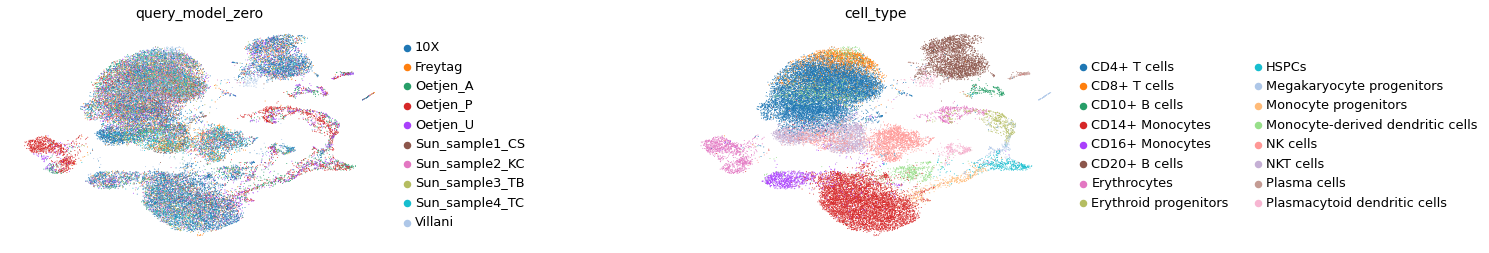

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


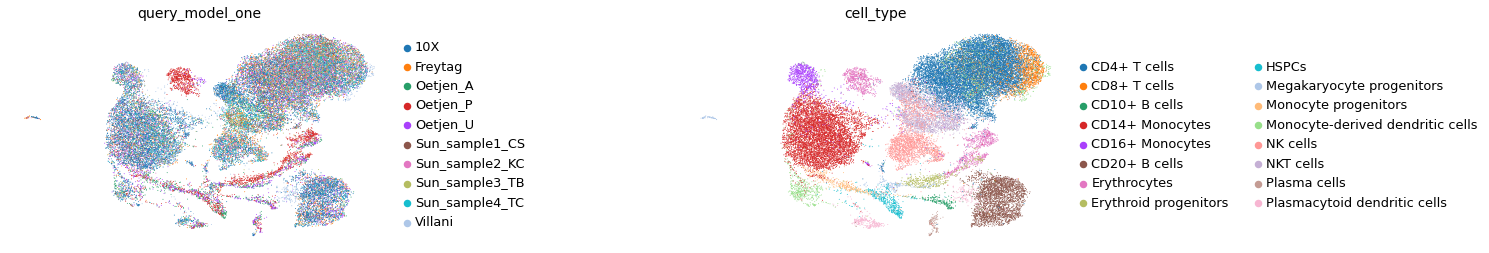

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


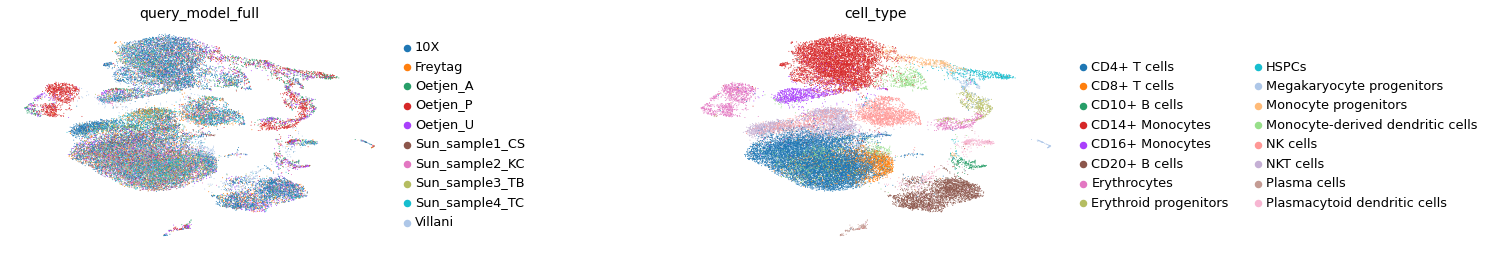

In [142]:
for i in range(len(full_latent_array)):
    sc.pp.neighbors(full_latent_array[i], n_neighbors=8)
    sc.tl.leiden(full_latent_array[i])
    sc.tl.umap(full_latent_array[i])
    sc.pl.umap(full_latent_array[i],
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           title = surg_path[i]
           )

## Benchmarking for Biological Conservation and Batch Correction

In [143]:
results_array = []

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [144]:
full_latent_array

[AnnData object with n_obs × n_vars = 33506 × 10
     obs: 'cell_type', 'batch', 'leiden'
     uns: 'neighbors', 'leiden', 'umap', 'batch_colors', 'cell_type_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 33506 × 10
     obs: 'cell_type', 'batch', 'leiden'
     uns: 'neighbors', 'leiden', 'umap', 'batch_colors', 'cell_type_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 33506 × 10
     obs: 'cell_type', 'batch', 'leiden'
     uns: 'neighbors', 'leiden', 'umap', 'batch_colors', 'cell_type_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities']

In [145]:
adata.obs['cell_type'] = adata.obs['final_annotation']

In [146]:
for i in range(len(full_latent_array)):
    results = scib.metrics.metrics(
        adata, full_latent_array[i],
        batch_key= 'batch',label_key = 'cell_type', organism= 'human', subsample=1., embed = 'X_umap',
        graph_conn_=True, nmi_ = True, ari_ = True,
        ilisi_=False, isolated_labels_asw_= True, cell_cycle_= True,
        silhouette_=True
    )
    results_array.append(results)

NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...
NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...
NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...


In [147]:
def median_bio_conserv(results):
    column = results[0]
    return (column.iloc[0] + column.iloc[1] + column.iloc[2] + column.iloc[4])/4

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [148]:
def median_batch_corr(results):
    column = results[0]
    return (column.iloc[3] + column.iloc[5] + column.iloc[6])/3

# Results

In [149]:
results_zero = results_array[0].dropna()


In [150]:
print('Zero shot: ')
print(f"bio_conservation = {median_bio_conserv(results=results_zero)}")
print(f"batch_correction = {median_batch_corr(results=results_zero)}")
results_zero

Zero shot: 
bio_conservation = 0.6061187083066747
batch_correction = 0.742720438213751


,0
NMI_cluster/label,0.744682
ARI_cluster/label,0.693664
ASW_label,0.573844
ASW_label/batch,0.711948
cell_cycle_conservation,0.412286
isolated_label_silhouette,0.571632
graph_conn,0.944581


In [151]:
results_one = results_array[1].dropna()

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [152]:
print('One shot: ')
print(f"batch_correction = {median_bio_conserv(results=results_one)}")
print(f"batch_correction = {median_batch_corr(results=results_one)}")
results_one

One shot: 
batch_correction = 0.5877936000077439
batch_correction = 0.722581268662319


,0
NMI_cluster/label,0.736899
ARI_cluster/label,0.687747
ASW_label,0.553542
ASW_label/batch,0.713152
cell_cycle_conservation,0.372986
isolated_label_silhouette,0.526834
graph_conn,0.927758


In [153]:
results_full = results_array[2].dropna()

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [154]:
print('Full query: ')
print(f"bio_conservation = {median_bio_conserv(results=results_full)}")
print(f"batch_correction = {median_batch_corr(results=results_full)}")
results_full

Full query: 
bio_conservation = 0.6134409345413349
batch_correction = 0.7444805160287649


,0
NMI_cluster/label,0.752191
ARI_cluster/label,0.718896
ASW_label,0.565590
ASW_label/batch,0.721947
cell_cycle_conservation,0.417087
isolated_label_silhouette,0.567801
graph_conn,0.943693
